# (3) Notebook for running analyses on the sampled data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sys
import os
import multiprocessing
import numpy as np
import ast
import importlib
from collections import Counter
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv('all_bootstrapped_v3.csv')

In [4]:
df

,ages,sample_no,sample_index,mean_infor,mean_logfreq
0,3-9,100,0,3.289338,6.284536
1,3-9,100,1,3.255210,6.275662
2,3-9,100,2,3.272207,6.311321
3,3-9,100,3,3.260396,6.268527
4,3-9,100,4,3.256225,6.260214
...,...,...,...,...,...
795,45-51,100,95,3.301410,6.333735
796,45-51,100,96,3.286202,6.338449
797,45-51,100,97,3.298132,6.325227
798,45-51,100,98,3.282511,6.333397


This is where we replace exclusive labeling system with inclusive labeling system (as seen below)

In [5]:
agebins = ['3-9', '9-15', '15-21', '21-27', '27-33', '33-39', '39-45']
inclusive_labels = ['3-8', '9-14', '15-20', '21-26', '27-32', '33-38', '39-44']
df = df[df['ages'].isin(agebins)]

In [15]:
import glob
path = None #insert link to bootstrapBackendFolder  
all_files = glob.glob(os.path.join(path, "sample_*_age_*_phonemic.csv"))

dataframes = []

# Process each file
for file in all_files:
    # Extract the agebin from the filename
    agebin = file.split("_age_")[1].split("_phonemic")[0]
    sample_index = file.split('_')[1]
    # Read the CSV file
    loop_df = pd.read_csv(file)
    
    # Add an 'agebin' column
    loop_df['agebin'] = agebin
    loop_df['sample_index'] = sample_index
    # Append to the list of dataframes
    dataframes.append(loop_df)

# Combine all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

In [16]:
combined_df

,phoneme,freq_values,info_values,agebin,sample_index
0,b,5.221246,3.594990,3-9,0
1,i,3.934856,1.833825,3-9,0
2,d,4.530350,2.925577,3-9,0
3,ɑ,5.019323,3.671316,3-9,0
4,l,4.627446,2.826048,3-9,0
...,...,...,...,...,...
36782,g,8.255697,6.527356,33-39,99
36783,θ,8.140638,2.962072,33-39,99
36784,l̩,8.197021,2.665218,33-39,99
36785,ʒ,11.661689,3.924415,33-39,99


## Initial ANOVA analysis

In [6]:
mean_infor_samples = []

for age in agebins:
    subset_age = df[df['ages'] == age]
    mean_infor_samples.append(subset_age['mean_infor'])

In [7]:
f_stat, pvalue = scipy.stats.f_oneway(*mean_infor_samples, axis=0)
k = 7        # Number of groups
N = 700      # Total number of observations
df_between = k - 1
df_within = N - k
eta_squared = (f_stat * df_between) / ((f_stat * df_between) + df_within) # Partial eta squared

In [9]:
print("ANOVA results for informativity")
print(f_stat,pvalue,eta_squared)

ANOVA results for informativity
929.0262419271198 0.0 0.8894235536036836


In [10]:
mean_logfreq_samples = []

for age in agebins:
    subset_age = df[df['ages'] == age]
    mean_logfreq_samples.append(subset_age['mean_logfreq'])
    
f_stat, pvalue = scipy.stats.f_oneway(*mean_logfreq_samples, axis=0)
k = 7  
N = 700  
df_between = k - 1
df_within = N - k
eta_squared = (f_stat * df_between) / ((f_stat * df_between) + df_within)

In [11]:
print("ANOVA results for frequency")
print(f_stat,pvalue,eta_squared)

ANOVA results for frequency
24.9357863569055 7.51617938657718e-27 0.17756005790100635


## Outlier detection 

In [14]:
def remove_outliers_iqr(df, category_col, value_col):
    def iqr_outlier_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
    
    return df.groupby(category_col, group_keys=False).apply(iqr_outlier_filter)

# Remove outliers
filtered_data_infor = remove_outliers_iqr(df, 'ages', 'mean_infor')
filtered_data_logfreq = remove_outliers_iqr(df, 'ages', 'mean_logfreq')

## Correlation scatterplots between informativity and frequency

<Figure size 936x648 with 0 Axes>

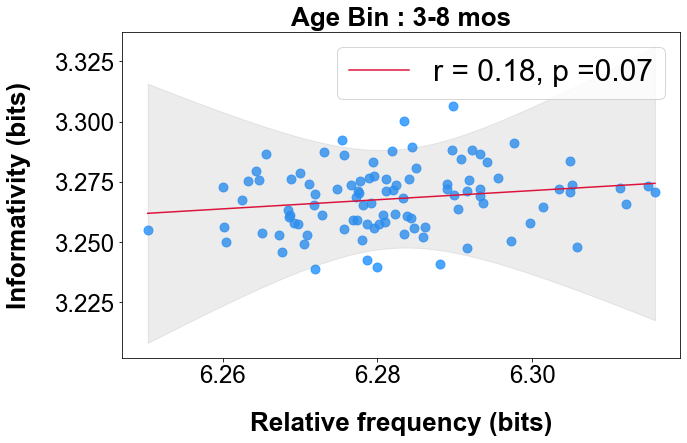

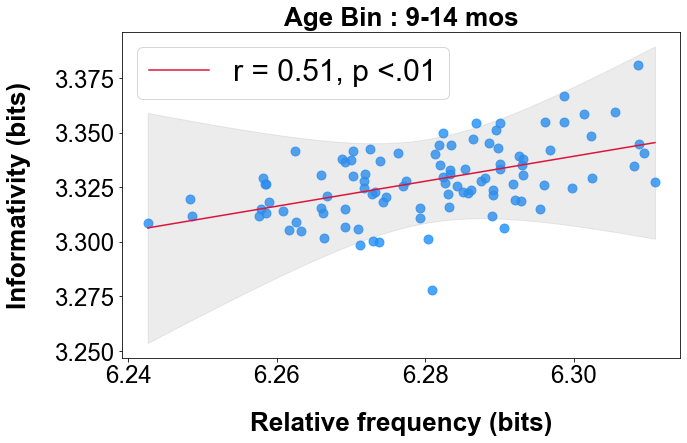

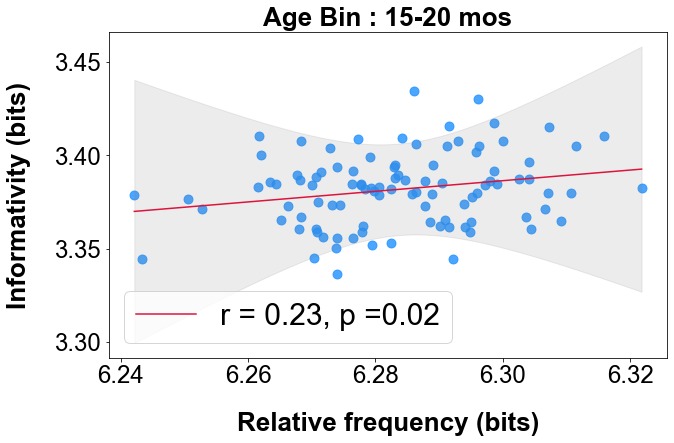

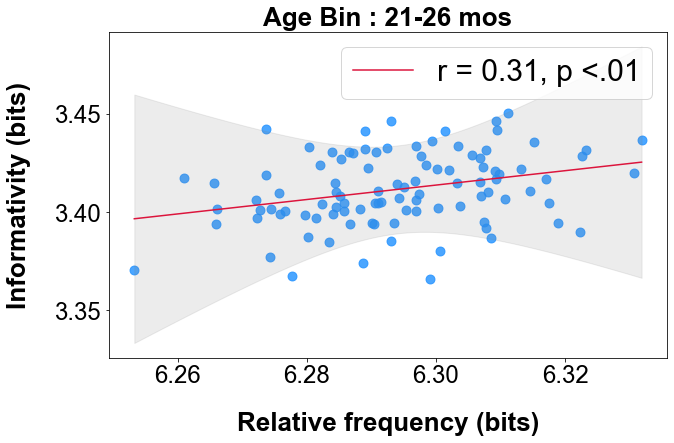

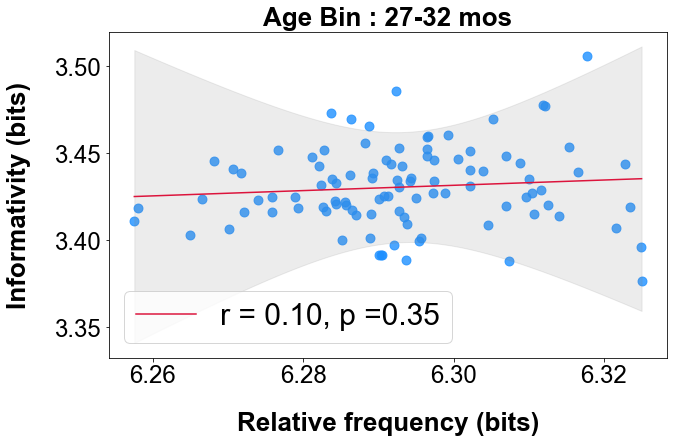

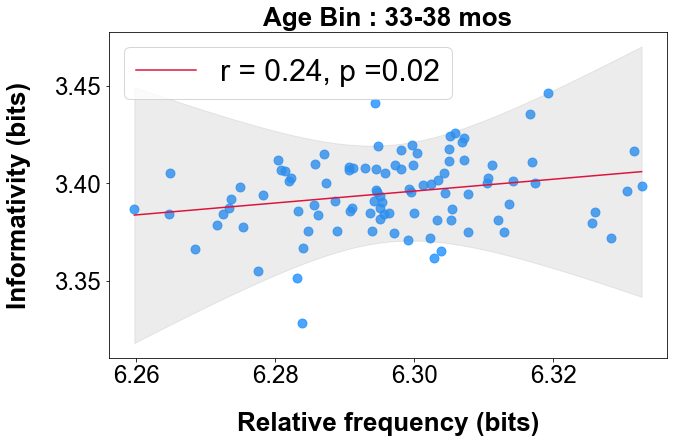

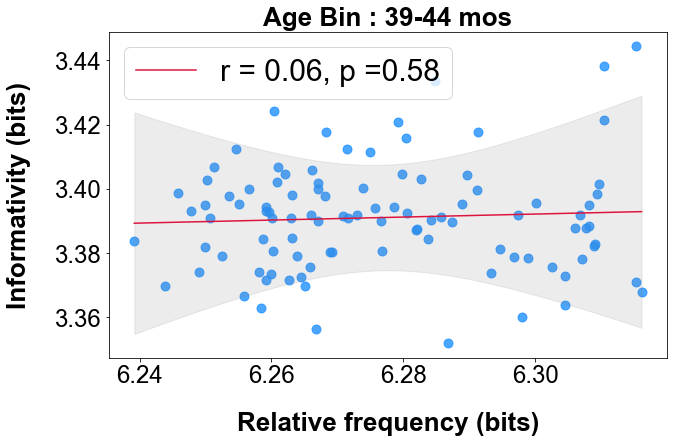

In [15]:
from scipy.stats import linregress
myblue = "#1E90FF" 
myred =  "#DC143C" 
rvalues = []
nvalues = []
with plt.rc_context({
    'font.size': 30,        # General font size
    'axes.titlesize': 26,   # Font size for the title
    'axes.labelsize': 26,   # Font size for x and y labels
    'xtick.labelsize': 24,  # Font size for x-axis tick labels
    'ytick.labelsize': 24,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
    plt.figure(figsize=(13,9))
    
    for i in range(len(agebins)):
        age = agebins[i]
        inclusive_age = inclusive_labels[i]
        subset_age = filtered_data_logfreq[filtered_data_logfreq['ages'] == age]
        x = subset_age['mean_logfreq']
        y = subset_age['mean_infor']
        slope, intercept, r_value, p_value, std_err = linregress(subset_age['mean_logfreq'], subset_age['mean_infor'])
        #line = slope * x + intercept
        
        
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept


        rounded_p = round(p_value,2)
        nvalues.append(len(subset_age))
        rvalues.append(r_value)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, alpha=0.8,color=myblue,s=80)
        
        if rounded_p < 0.01:
            rounded_p = "<.01"
        else:
            rounded_p = "="+str(round(p_value,2))
            
            
        confidence = 1.96  # Approx for 95% confidence interval
        y_err = confidence * std_err * np.sqrt(1 / len(x) + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='gray', alpha=0.15)
            
        plt.plot(x_fit, y_fit, color=myred, label=f'r = {r_value:.2f}, p {rounded_p}')
        plt.title('Age Bin : '+ inclusive_age +' mos' , fontsize=26, fontweight='bold')
        plt.xlabel('Relative frequency (bits)', fontweight="bold",labelpad=24)
        plt.ylabel('Informativity (bits)', fontweight="bold",labelpad=24)
        plt.legend()
        
        # Uncomment below line to save plots locally
        #plt.savefig('scatterplot_'+inclusive_age+'.pdf', format='pdf',bbox_inches='tight')
        
        plt.show()

In [16]:
print ("Mean Pearson's r:", np.mean(rvalues), "SD Pearson's r:", np.std(rvalues))

Mean Pearson's r: 0.23147358652475483 SD Pearson's r: 0.13880792338325668


In [195]:
from scipy.stats import norm
def fisher_r_to_z(r):
    return np.arctanh(r)   

def compareFisher(r1,r2,n1,n2):
    z1 = fisher_r_to_z(r1)
    z2 = fisher_r_to_z(r2)

    # Standard error for the difference between two z-scores
    se_diff = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))

    # Z-test statistic for comparing correlations
    z_score = (z1 - z2) / se_diff

    # Two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    print(f"Fisher Z for r1: {z1:.4f}")
    print(f"Fisher Z for r2: {z2:.4f}")
    print(f"Z-score for comparison: {z_score:.4f}")
    print(f"P-value: {p_value:.4f}")

In [197]:
for i in range(6):
    j=i+1
    print(agebins[i], agebins[j])
    compareFisher(rvalues[i],rvalues[j],nvalues[i],nvalues[j])
    print('\n')

3-9 9-15
Fisher Z for r1: 0.1849
Fisher Z for r2: 0.5620
Z-score for comparison: -2.6193
P-value: 0.0088


9-15 15-21
Fisher Z for r1: 0.5620
Fisher Z for r2: 0.2299
Z-score for comparison: 2.3064
P-value: 0.0211


15-21 21-27
Fisher Z for r1: 0.2299
Fisher Z for r2: 0.3191
Z-score for comparison: -0.6196
P-value: 0.5356


21-27 27-33
Fisher Z for r1: 0.3191
Fisher Z for r2: 0.0959
Z-score for comparison: 1.5507
P-value: 0.1210


27-33 33-39
Fisher Z for r1: 0.0959
Fisher Z for r2: 0.2463
Z-score for comparison: -1.0390
P-value: 0.2988


33-39 39-45
Fisher Z for r1: 0.2463
Fisher Z for r2: 0.0564
Z-score for comparison: 1.3154
P-value: 0.1884




In [19]:
print("Looking at Spearman Ranked Correlation values \n")
for age in agebins:
    subset_age = df[df['ages'] == age]
    print("AGE",  age, scipy.stats.spearmanr(a=subset_age['mean_logfreq'],b=subset_age['mean_infor']))

Looking at Spearman Ranked Correlation values 

AGE 3-9 SpearmanrResult(correlation=0.1673087308730873, pvalue=0.0961519805273376)
AGE 9-15 SpearmanrResult(correlation=0.5035583558355835, pvalue=9.281809359186505e-08)
AGE 15-21 SpearmanrResult(correlation=0.19680768076807678, pvalue=0.049695834461166905)
AGE 21-27 SpearmanrResult(correlation=0.3091389138913891, pvalue=0.0017507054873415597)
AGE 27-33 SpearmanrResult(correlation=0.1245244524452445, pvalue=0.21705399482877993)
AGE 33-39 SpearmanrResult(correlation=0.19153915391539153, pvalue=0.0562588029032764)
AGE 39-45 SpearmanrResult(correlation=0.009792979297929792, pvalue=0.9229639418675957)


## Post hoc analyses

First, trying a Bonferroni correction

### Bonferroni correction applied to frequency

In [22]:
import scipy.stats as stats
results = []
for i in range(len(agebins)-1):
        data1 = df[df['ages'] == agebins[i]]['mean_logfreq']
        data2 = df[df['ages'] == agebins[i+1]]['mean_logfreq']
        stat, p = stats.ttest_ind(data1, data2)
        
        bonferroni_alpha = 0.05 / 6 
        significant = p < bonferroni_alpha
        mean_diff = data1.mean() - data2.mean() 
        results.append((agebins[i], agebins[i+1], stat, p, mean_diff,significant))

# Convert results to DataFrame for easier viewing
bonfresults_df_rf = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'Statistic', 'P-value', 'Group1-Group2 Mean','Significant'])
print(bonfresults_df_rf)

  Group 1 Group 2  Statistic       P-value  Group1-Group2 Mean  Significant
0     3-9    9-15   0.994716  3.210883e-01            0.001992        False
1    9-15   15-21  -1.691958  9.222715e-02           -0.003759        False
2   15-21   21-27  -4.391026  1.835211e-05           -0.009980         True
3   21-27   27-33   0.190696  8.489594e-01            0.000415        False
4   27-33   33-39  -1.670242  9.645161e-02           -0.003684        False
5   33-39   39-45   8.100970  5.504999e-14            0.020943         True


In [23]:
bonfresults_df_rf['P-value'] = bonfresults_df_rf['P-value'].apply(lambda x: f"{x:.2e}")
bonfresults_df_rf['Statistic'] = bonfresults_df_rf['Statistic'].round(2)
bonfresults_df_rf['Group1-Group2 Mean'] = bonfresults_df_rf['Group1-Group2 Mean'].round(2)
#print(bonfresults_df_rf.to_latex(index=False))

In [24]:
bonfresults_df_rf['Statistic']
bonfresults_df_rf['Group1-Group2 Mean']
bonfresults_df_rf['Significant']

0    False
1    False
2     True
3    False
4    False
5     True
Name: Significant, dtype: bool

### Bonferroni correction applied to  informativity

In [25]:
results = []
for i in range(len(agebins)-1):
        j = i+1
        data1 = df[df['ages'] == agebins[i]]['mean_infor']
        data2 = df[df['ages'] == agebins[j]]['mean_infor']
        stat, p = stats.ttest_ind(data1, data2)
        
        bonferroni_alpha = 0.05 / 6 
        significant = p < bonferroni_alpha
        mean_diff = data1.mean() - data2.mean() 
        results.append((agebins[i], agebins[j], stat, p, mean_diff,significant))

# Convert results to DataFrame for easier viewing
bonfresults_df = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'Statistic', 'P-value', 'Group1-Group2 Mean','Significant'])
print(bonfresults_df)

  Group 1 Group 2  Statistic       P-value  Group1-Group2 Mean  Significant
0     3-9    9-15 -28.074915  5.867600e-71           -0.060231         True
1    9-15   15-21 -21.027679  2.396159e-52           -0.053651         True
2   15-21   21-27 -11.158334  9.563800e-23           -0.029843         True
3   21-27   27-33  -6.424441  9.640712e-10           -0.018981         True
4   27-33   33-39  11.960161  3.632556e-25            0.035759         True
5   33-39   39-45   1.447086  1.494542e-01            0.003681        False


In [26]:
bonfresults_df['P-value'] = bonfresults_df['P-value'].apply(lambda x: f"{x:.2e}")
bonfresults_df['Statistic'] = bonfresults_df['Statistic'].round(2)
bonfresults_df['Group1-Group2 Mean'] = bonfresults_df['Group1-Group2 Mean'].round(2)

In [27]:
bonfresults_df = bonfresults_df.round(3)

In [28]:
bonfresults_df.columns=['Reference age bin' , 'Comparison age bin',  't statistic [INF]', 'p value', 'Difference between means [INF]','Sig']

In [29]:
bonfresults_df['Sig'] = np.where(bonfresults_df['Sig'],'***','')

In [30]:
bonfresults_df['t statistic [RF]'] = bonfresults_df_rf['Statistic']
bonfresults_df['Difference between means [RF]'] = bonfresults_df_rf['Group1-Group2 Mean']
bonfresults_df['SIG [RF]'] = bonfresults_df_rf['Significant']
bonfresults_df['SIG [RF]'] = np.where(bonfresults_df['SIG [RF]'],'***','')

In [23]:
bonfresults_df

,Reference age bin,Comparison age bin,t statistic [INF],p value,Difference between means [INF],Sig,t statistic [RF],Difference between means [RF],SIG [RF]
0,3-9,9-15,-28.07,5.87e-71,-0.06,***,0.99,0.00,
1,9-15,15-21,-21.03,2.40e-52,-0.05,***,-1.69,-0.00,
2,15-21,21-27,-11.16,9.56e-23,-0.03,***,-4.39,-0.01,***
3,21-27,27-33,-6.42,9.64e-10,-0.02,***,0.19,0.00,
4,27-33,33-39,11.96,3.63e-25,0.04,***,-1.67,-0.00,
5,33-39,39-45,1.45,1.49e-01,0.00,,8.10,0.02,***


In [24]:
bonfresults_df = bonfresults_df.drop('p value',axis=1)

In [25]:
bonfresults_df['Difference between means [INF]'] = bonfresults_df['Difference between means [INF]'].astype(str) +  bonfresults_df['Sig']
bonfresults_df['Difference between means [RF]'] = bonfresults_df['Difference between means [RF]'].astype(str) +  bonfresults_df['SIG [RF]']

In [26]:
bonfresults_df = bonfresults_df.drop('Sig',axis=1)
bonfresults_df = bonfresults_df.drop('SIG [RF]',axis=1)

In [31]:
# Uncomment below line for generating latex table

# print(bonfresults_df.to_latex(index=False ))

### Tukey HSD on frequency

In [87]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
tukey = pairwise_tukeyhsd(endog=df['mean_logfreq'],     
                          groups=df['ages'],             
                          alpha=0.05)                      

 
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 15-21  21-27     0.01 0.0002  0.0033  0.0167   True
 15-21  27-33   0.0096 0.0004  0.0029  0.0163   True
 15-21    3-9  -0.0018 0.9929 -0.0085  0.0049  False
 15-21  33-39   0.0132    0.0  0.0066  0.0199   True
 15-21  39-45  -0.0077 0.0116 -0.0144  -0.001   True
 15-21  45-51   0.0397    0.0   0.033  0.0464   True
 15-21   9-15  -0.0038 0.6816 -0.0104  0.0029  False
 21-27  27-33  -0.0004    1.0 -0.0071  0.0063  False
 21-27    3-9  -0.0117    0.0 -0.0184 -0.0051   True
 21-27  33-39   0.0033 0.8149 -0.0034    0.01  False
 21-27  39-45  -0.0177    0.0 -0.0244  -0.011   True
 21-27  45-51   0.0297    0.0  0.0231  0.0364   True
 21-27   9-15  -0.0137    0.0 -0.0204 -0.0071   True
 27-33    3-9  -0.0113    0.0  -0.018 -0.0046   True
 27-33  33-39   0.0037 0.7038  -0.003  0.0104  False
 27-33  39-45  -0.0173    0.0 -0.0239 -0.0106 

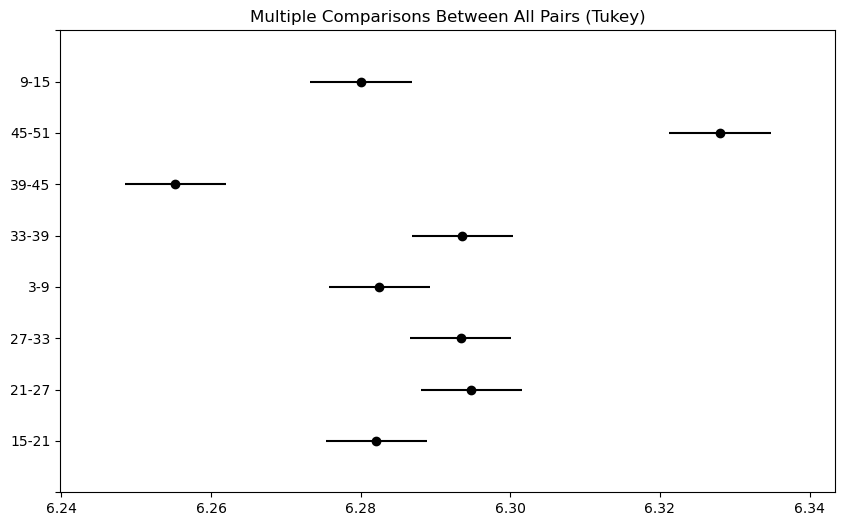

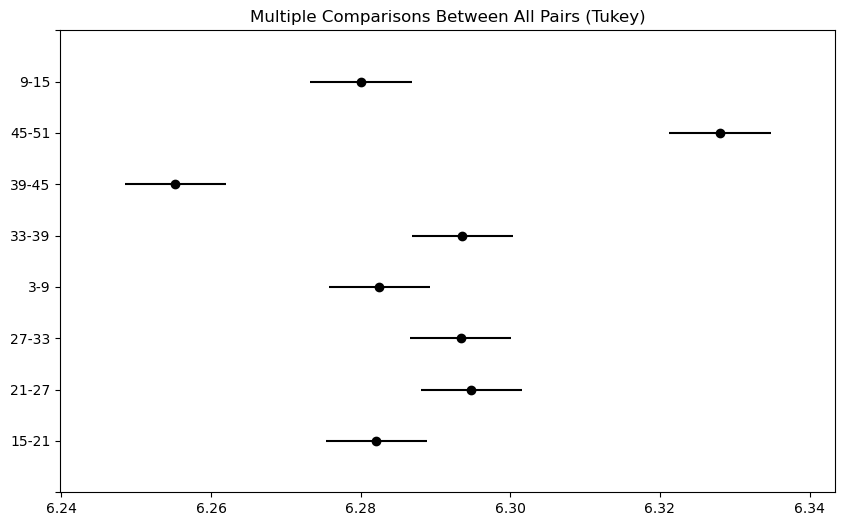

In [113]:
tukey.plot_simultaneous() 

### Tukey HSD on informativity

In [88]:
tukey = pairwise_tukeyhsd(endog=df['mean_infor'],      
                          groups=df['ages'],             
                          alpha=0.05)                      


print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 15-21  21-27   0.0298    0.0   0.022  0.0377   True
 15-21  27-33   0.0488    0.0   0.041  0.0566   True
 15-21    3-9  -0.1139    0.0 -0.1217 -0.1061   True
 15-21  33-39   0.0131    0.0  0.0052  0.0209   True
 15-21  39-45   0.0094 0.0068  0.0016  0.0172   True
 15-21  45-51  -0.0879    0.0 -0.0957 -0.0801   True
 15-21   9-15  -0.0537    0.0 -0.0615 -0.0458   True
 21-27  27-33    0.019    0.0  0.0112  0.0268   True
 21-27    3-9  -0.1437    0.0 -0.1515 -0.1359   True
 21-27  33-39  -0.0168    0.0 -0.0246  -0.009   True
 21-27  39-45  -0.0205    0.0 -0.0283 -0.0126   True
 21-27  45-51  -0.1178    0.0 -0.1256 -0.1099   True
 21-27   9-15  -0.0835    0.0 -0.0913 -0.0757   True
 27-33    3-9  -0.1627    0.0 -0.1705 -0.1549   True
 27-33  33-39  -0.0358    0.0 -0.0436 -0.0279   True
 27-33  39-45  -0.0394    0.0 -0.0473 -0.0316 

## Generating plots

In [38]:
custom_palette =[
    "#1E90FF",  # Sky Blue
    "#DC143C",  # Crimson Red
    "#FFD700",  # Sunflower Yellow
    "#50C878",  # Emerald Green
    "#FF6347",  # Tangerine Orange
    "#7851A9",  # Royal Purple
    "#708090",   # Slate Gray,
    "#20B2AA"  # Cool Teal 
]
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [34]:
def add_significance_bars(ax, x1, x2, y, significance_level=0.05):
    """Add significance bars to a boxplot."""
    y_offset = 0.0035  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='blue')
    ax.text((x1 + x2) / 2, y + y_offset + 0.0001, '*', fontsize=16, ha='center',color='blue')

In [35]:
def add_significance_bars(ax, x1, x2, y, significance_level=0.05):
    """Add significance bars to a boxplot."""
    y_offset = 0.002  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black')
    ax.text((x1 + x2) / 2, y + y_offset+0.0001  , '***', fontsize=26, ha='center',color='black')

In [36]:
means_infor =  [3.268,  
3.328, 
3.382,  
3.412, 
3.431,
3.395,
3.391]

means_lf =  [6.282,  
6.280, 
6.284,  
6.294, 
6.294,
6.297,
6.277]

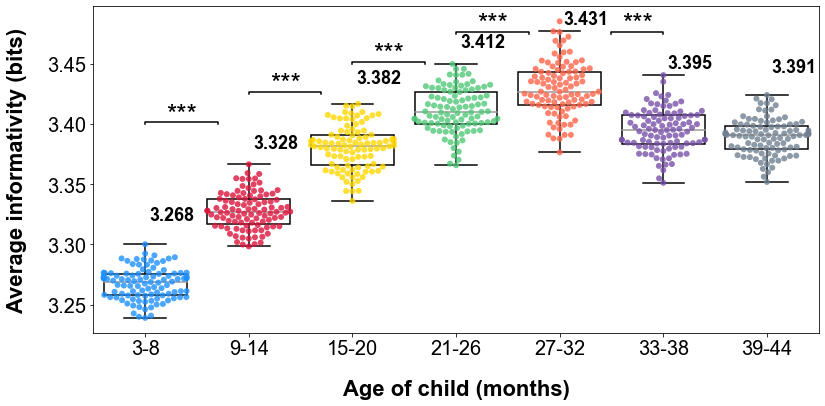

In [39]:
with plt.rc_context({
    'font.size': 12,        # General font size
    'axes.titlesize': 20,   # Font size for the title
    'axes.labelsize': 22,   # Font size for x and y labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
 
    plt.figure(figsize=(13, 6))

    ax = sns.boxplot(x='ages', y='mean_infor', data=filtered_data_infor, order=agebins, 
                  linewidth=1.5, fliersize=0,color='white', boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   


    sns.swarmplot(x='ages', y='mean_infor', hue='ages', data=filtered_data_infor, size=6, 
                  palette=custom_palette, order=agebins, edgecolor='black', dodge=False,alpha=0.8,hue_order=agebins)
    
    for i in range(4):
        add_significance_bars(ax, i, i +0.7, 3.4+i/40)
    add_significance_bars(ax, 4.5, 5, 3.4+3/40)
        
    for i in range(7):
        plt.annotate(str(means_infor[i]), fontweight='bold', xytext=(i+0.04, means_infor[i]+0.052),xy=(i+0.04, means_infor[i]+0.05),fontsize=18)
 
    plt.xlabel('Age of child (months)', fontweight="bold",labelpad=20)
    plt.ylabel('Average informativity (bits)', fontweight="bold",labelpad=20)
    plt.xticks(ticks=[i for i in range(7)], labels=inclusive_labels )
    plt.legend().set_visible(False) 
    
    #Uncomment below line to save plot locally
    #plt.savefig('informativity_boxplot.pdf', format='pdf',bbox_inches='tight')
    plt.show()


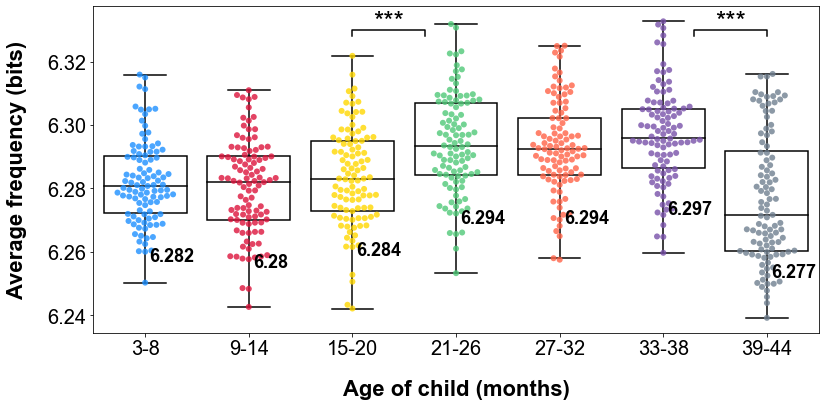

In [40]:
with plt.rc_context({
    'font.size': 12,        # General font size
    'axes.titlesize': 20,   # Font size for the title
    'axes.labelsize': 22,   # Font size for x and y labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
    plt.figure(figsize=(13,6))

    ax = sns.boxplot(x='ages', y='mean_logfreq', data=filtered_data_logfreq, order=agebins, 
                  linewidth=1.5, fliersize=0,color='white',boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   
    for line in ax.lines:
        line.set_color('black')   

    ax2 = sns.swarmplot(x='ages', y='mean_logfreq', hue='ages', data=filtered_data_logfreq, size=6, 
                  palette=custom_palette, order=agebins, edgecolor='black', dodge=False,alpha=0.8,hue_order=agebins)
    ax2.legend_.remove()
    
    
    add_significance_bars(ax, 2, 2.7, 6.328)
    add_significance_bars(ax, 5.3, 6, 6.328)
    
    for i in range(7):
        plt.annotate(str(means_lf[i]), fontweight='bold', xytext=(i+0.04, means_lf[i]-0.025),xy=(i+0.04, means_lf[i]-0.025),fontsize=18)
    
    plt.xlabel('Age of child (months)', fontweight="bold",labelpad=20)
    plt.ylabel('Average frequency (bits)', fontweight="bold",labelpad=20)
    plt.xticks(ticks=[i for i in range(7)], labels=inclusive_labels )
    
    #Uncomment below line to save plot locally
    #plt.savefig('relfreq_boxplot.pdf', format='pdf',bbox_inches='tight')
    
    plt.show()


## One of two scrambling analyses : point scrambling technique

In [41]:
df_shuffled = df.copy() 
df_shuffled['original_age'] = df_shuffled['ages']
df_shuffled['ages'] = np.random.RandomState(seed=0).permutation(df['ages'].values)

In [42]:
replacement_dict = dict(zip(agebins, inclusive_labels))
df_shuffled['inclusive_labels'] = df_shuffled['original_age'].replace(replacement_dict)

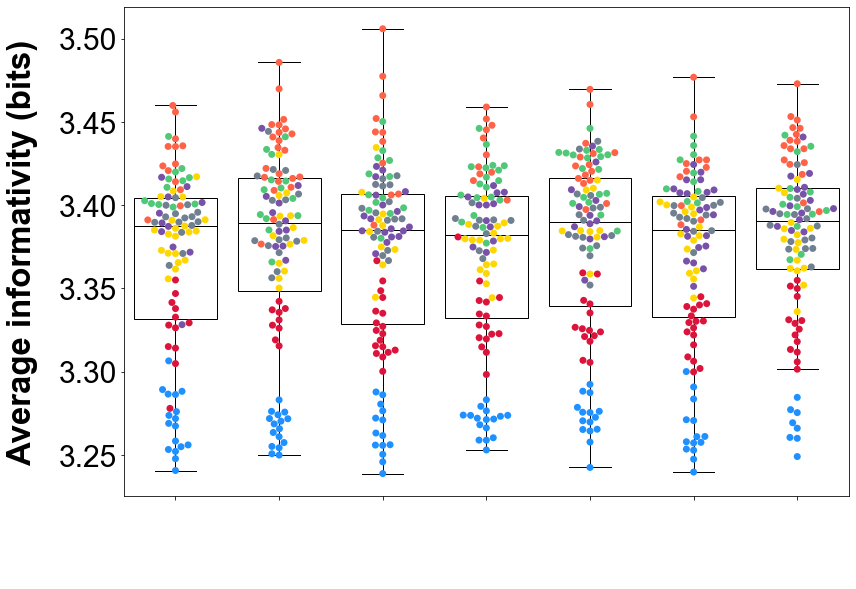

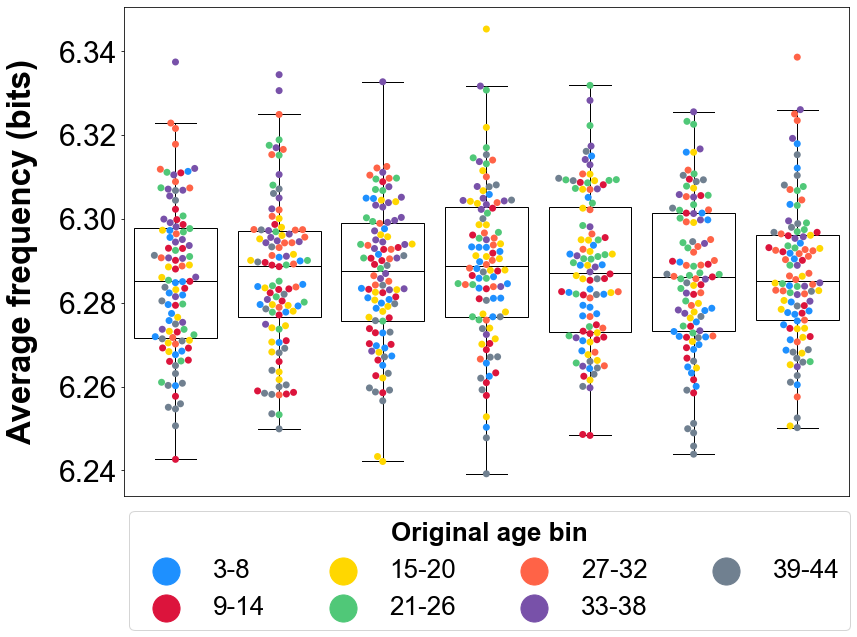

In [43]:
with plt.rc_context({
    'font.size': 28,        # General font size
    'axes.titlesize': 30,   # Font size for the title
    'axes.labelsize': 33,   # Font size for x and y labels
    'xtick.labelsize': 30,  # Font size for x-axis tick labels
    'ytick.labelsize': 30,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
    plt.figure(figsize=(13,9))


    ax = sns.boxplot(x='ages', y='mean_infor', data=df_shuffled,   
                  linewidth=1, fliersize=0,color='white',boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   
    for line in ax.lines:
        line.set_color('black')   

    ax2 = sns.swarmplot(x='ages', y='mean_infor', hue='original_age', data=df_shuffled, size=7, 
                     edgecolor='gray', dodge=False,palette=custom_palette)
    
    plt.ylabel('Average informativity (bits)', fontweight="bold",labelpad=20)
    plt.xlabel('')
    plt.legend().set_visible(False)
    plt.xticks(color='white') 
    plt.xlabel('Hi', fontweight="bold",labelpad=20, color='white')
    #Uncomment below line to save plot locally
    #plt.savefig('infor_fullscramble.pdf', format='pdf',bbox_inches='tight')
    plt.show()

    
with plt.rc_context({
    'font.size': 26,        # General font size
    'axes.titlesize': 30,   # Font size for the title
    'axes.labelsize': 33,   # Font size for x and y labels
    'xtick.labelsize': 30,  # Font size for x-axis tick labels
    'ytick.labelsize': 30,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
 
    plt.figure(figsize=(13,9))

    ax = sns.boxplot(x='ages', y='mean_logfreq', data=df_shuffled, order=agebins, 
                  linewidth=1, fliersize=0,color='white',boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   

    for line in ax.lines:
        line.set_color('black') 
    
    sns.swarmplot(x='ages', y='mean_logfreq', hue='inclusive_labels', data=df_shuffled, size=7, 
                    order=agebins, edgecolor='gray', dodge=False,palette=custom_palette)
    plt.legend().set_visible(False)
    plt.xticks([])
    plt.xlabel(' ', fontweight="bold",labelpad=20, color='white')
    plt.ylabel('Average frequency (bits)', fontweight="bold",labelpad=20)
    legend = plt.legend(loc='lower left', bbox_to_anchor=(-0.01, -0.3), title='Original age bin',ncol=4,markerscale=3.5)
    legend.get_title().set_fontweight('bold')
    #Uncomment below line to save plot locally
    #plt.savefig('relfreq_fullscramble.pdf', format='pdf',bbox_inches='tight')
    plt.show()

### ANOVA testing after point scrambling

In [48]:
mean_logfreq_samples_shuffled = []

for age in agebins:
    subset_age = df_shuffled[df_shuffled['ages'] == age]
    mean_logfreq_samples_shuffled.append(subset_age['mean_logfreq'])
    
f_stat, p_val = scipy.stats.f_oneway(*mean_logfreq_samples_shuffled, axis=0)

In [49]:
k = 7  
N = 700  
df_between = k - 1
df_within = N - k
eta_squared = (f_stat * df_between) / ((f_stat * df_between) + df_within)
print('Frequency results:')
print(f_stat, p_val, eta_squared)

Frequency results:
0.4066167182965258 0.8748535816792806 0.003508140689541316


In [50]:
mean_infor_samples_shuffled = []

for age in agebins:
    subset_age = df_shuffled[df_shuffled['ages'] == age]
    mean_infor_samples_shuffled.append(subset_age['mean_infor'])
    
f_stat, p_val = scipy.stats.f_oneway(*mean_infor_samples_shuffled, axis=0)
eta_squared = (f_stat * df_between) / ((f_stat * df_between) + df_within)
print('Informativity results:')
print(f_stat, p_val, eta_squared)

Informativity results:
0.8715221991538198 0.5153568807956386 0.007489136368452151


### Finding outliers which need resampling

In [45]:
filtered_data_logfreq

,ages,sample_no,sample_index,mean_infor,mean_logfreq
201,15-21,100,1,3.398861,6.279124
202,15-21,100,2,3.360447,6.267972
203,15-21,100,3,3.360596,6.304451
204,15-21,100,4,3.387494,6.304176
205,15-21,100,5,3.410144,6.315879
...,...,...,...,...,...
195,9-15,100,95,3.324834,6.299811
196,9-15,100,96,3.329334,6.288036
197,9-15,100,97,3.328086,6.271789
198,9-15,100,98,3.300279,6.273026


In [50]:
expected_indices = set(range(100))

# Initialize a dictionary to store missing indices for each age
missing_per_age = {}

# Group by ages and check missing indices
for age, group in filtered_data_logfreq.groupby('ages'):
    present_indices = set(group['sample_index'].unique())
    missing_indices = expected_indices - present_indices
    if missing_indices:  # If there are missing indices
        missing_per_age[age] = sorted(missing_indices)

# Convert the result into a DataFrame for better readability
missing_indices_df = pd.DataFrame([
    {'age': age, 'missing_indices': indices}
    for age, indices in missing_per_age.items()
])


In [54]:
missing_indices_df
missing_indices_df.to_dict()

{'age': {0: '15-21',
  1: '21-27',
  2: '27-33',
  3: '3-9',
  4: '33-39',
  5: '39-45',
  6: '45-51',
  7: '9-15'},
 'missing_indices': {0: [0, 15, 30],
  1: [31],
  2: [59, 70, 83],
  3: [14, 93],
  4: [11, 25, 26, 29, 45, 84, 92, 97],
  5: [7, 24, 36, 47, 76, 78, 96, 97],
  6: [16, 24, 37, 65],
  7: [24, 35, 78, 91]}}

The above samples are considered outliers based on frequency, as they lie more than 1.5*IQR away from the quartiles.

In [51]:
missing_filenames = []

for _, row in missing_indices_df.iterrows():
    age = row['age']
    missing_indices = row['missing_indices']
    
    # Generate filenames for each missing index
    filenames = [f"sample_{index}_age_{age}_phonemic.csv" for index in missing_indices]
    missing_filenames.extend(filenames)

In [53]:
len(missing_filenames)

33

In [ ]:
data_path = None  # Path to the data directory of bootstrap backend  

# Here we check for outliers based on the informativity  values

def find_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Loop through each file and analyze
outlier_summary = []

for filename in missing_filenames:
    filepath = data_path + filename
    
    try:
        # Read the CSV
        phonemedf = pd.read_csv(filepath)
        
        # Check for outliers in 'info_values'
        outliers = find_outliers(phonemedf, 'info_values')
        
        # Visualize data distribution for 'info_values'
        plt.figure(figsize=(8, 6))
        plt.hist(phonemedf['info_values'], bins=20, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of info_values in {filename}')
        plt.xlabel('info_values')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
        # Record outlier details
        if not outliers.empty:
            outlier_summary.append({
                'filename': filename,
                'num_outliers': len(outliers),
                'outliers': outliers.to_dict('records')
            })
    
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Convert the outlier summary to a DataFrame for reporting
outlier_summary_df = pd.DataFrame(outlier_summary)
 

In [15]:
outlier_summary_df

,filename,num_outliers,outliers
0,sample_7_age_15-21_phonemic.csv,2,"[{'phoneme': 'ɔj', 'freq_values': 9.7199057083..."
1,sample_84_age_33-39_phonemic.csv,1,"[{'phoneme': 'g', 'freq_values': 8.55053303695..."
2,sample_7_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.4347173197..."
3,sample_15_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.7357430566..."
4,sample_24_age_39-45_phonemic.csv,2,"[{'phoneme': 'g', 'freq_values': 8.35723143342..."
5,sample_36_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.6613683854..."
6,sample_47_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.7818585830..."
7,sample_67_age_39-45_phonemic.csv,2,"[{'phoneme': 'g', 'freq_values': 8.58412538652..."
8,sample_76_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.5910859502..."
9,sample_78_age_39-45_phonemic.csv,1,"[{'phoneme': 'ɔj', 'freq_values': 9.9480822829..."


In [ ]:
# Here we check for outliers based on the frequency values

outlier_summary = []

for filename in missing_filenames:
    filepath = data_path + filename
    
    try:
        # Read the CSV
        phonemedf = pd.read_csv(filepath)
        
        # Check for outliers in 'info_values'
        outliers = find_outliers(phonemedf, 'freq_values')
        
        # Visualize data distribution for 'info_values'
        plt.figure(figsize=(8, 6))
        plt.hist(phonemedf['freq_values'], bins=20, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of logfreq in {filename}')
        plt.xlabel('freq_values')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
        # Record outlier details
        if not outliers.empty:
            outlier_summary.append({
                'filename': filename,
                'num_outliers': len(outliers),
                'outliers': outliers.to_dict('records')
            })
    
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Convert the outlier summary to a DataFrame for reporting
outlier_summary_df = pd.DataFrame(outlier_summary)

Based on our visualization and judgment, we decided to use frequency to decide which sampless were outliers because of the much higher discrepancies in the data.

This will be used to inform our resampling in the drawingSamples notebook

## The other (of the two) scrambling analyses : bin scrambling technique

In [51]:
randomized_age_order = np.random.RandomState(seed=0).permutation(agebins)

In [52]:
randomized_age_rows = [i for i in randomized_age_order for n in range(100) ]

In [53]:
df_shuffled = df.copy()
df_shuffled['original_age'] = df_shuffled['ages'].astype('category')
df_shuffled['ages'] = randomized_age_rows
df_shuffled['ages'] = pd.Categorical(df_shuffled['ages'], categories=agebins, ordered=True)
df_shuffled['original_age'] = pd.Categorical(df_shuffled['original_age'], categories=agebins, ordered=True)

In [54]:
randomized_age_order = list(randomized_age_order)
age_order = list(agebins)

category_series_random = pd.Series(randomized_age_order)

category_series_random  = pd.Categorical(category_series_random,ordered=True)

category_series  = pd.Series(age_order)

category_series   = pd.Categorical(category_series,ordered=True)

In [55]:
df_sorted_shuffled = df_shuffled.sort_values(by='ages')
sorted_original_age = df_sorted_shuffled['original_age']

In [56]:
list_of_ticks = sorted_original_age.unique()

In [58]:
list_of_ticks_inclusive = [replacement_dict.get(name, name) for name in list_of_ticks]

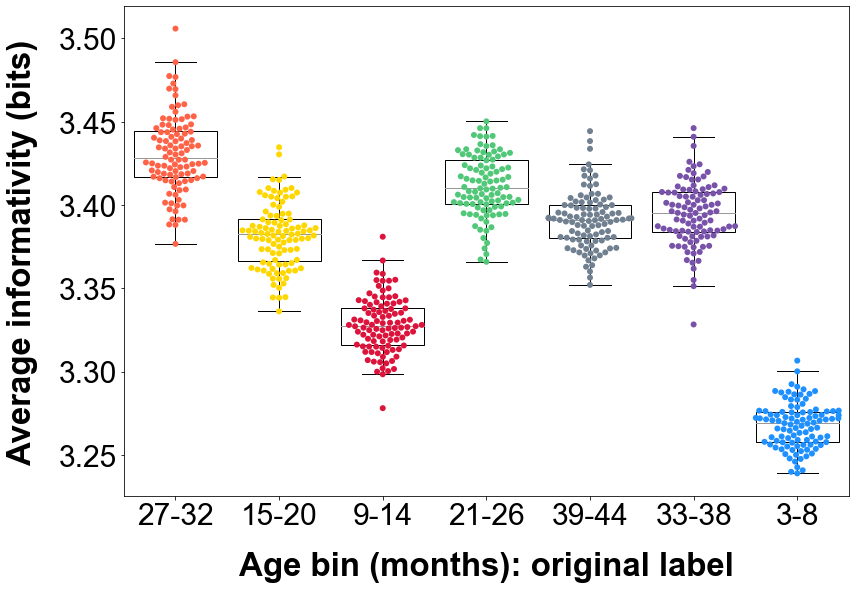

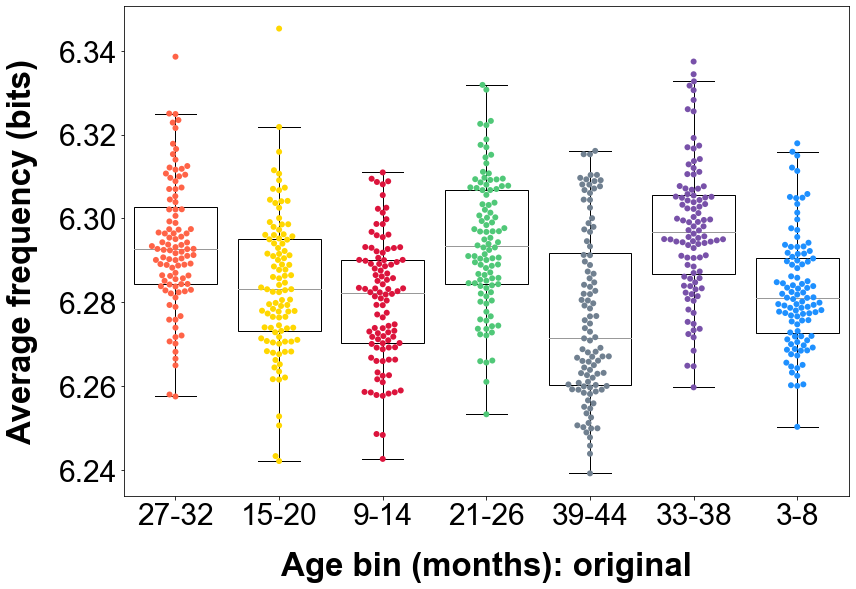

In [59]:
with plt.rc_context({
    'font.size': 30,        # General font size
    'axes.titlesize': 30,   # Font size for the title
    'axes.labelsize': 33,   # Font size for x and y labels
    'xtick.labelsize': 30,  # Font size for x-axis tick labels
    'ytick.labelsize': 30,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
 
    plt.figure(figsize=(13,9))


    sns.boxplot(x='ages', y='mean_infor', data=df_shuffled, order=agebins, 
                  linewidth=1, fliersize=0,color='white',boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   


    sns.swarmplot(x='ages', y='mean_infor', hue='original_age', data=df_shuffled, size=6, 
                  palette=custom_palette, order=agebins, edgecolor='gray', dodge=False)

    plt.xlabel('Age bin (months): original label',fontweight="bold",labelpad=20)
    plt.ylabel('Average informativity (bits)',fontweight="bold",labelpad=20)
    #plt.title('Informativity v/s Age (reordered)')
    plt.xticks(ticks=range(7), labels=list_of_ticks_inclusive)
    plt.legend().set_visible(False)  # Hides the legend
    #plt.savefig('info_rearranged_intact.pdf', format='pdf',bbox_inches='tight')
    plt.show()
    
with plt.rc_context({
    'font.size': 30,        # General font size
    'axes.titlesize': 30,   # Font size for the title
    'axes.labelsize': 33,   # Font size for x and y labels
    'xtick.labelsize': 30,  # Font size for x-axis tick labels
    'ytick.labelsize': 30,  # Font size for y-axis tick labels
    'font.family': 'Arial'  # Font family
}):
    plt.figure(figsize=(13,9))

   

    sns.boxplot(x='ages', y='mean_logfreq', data=df_shuffled, order=agebins, 
                  linewidth=1, fliersize=0,color='white',boxprops=dict(edgecolor='black'),whiskerprops=dict(color='black'),capprops=dict(color='black'))   


    sns.swarmplot(x='ages', y='mean_logfreq', hue='original_age', data=df_shuffled, size=6, 
                  palette=custom_palette, order=agebins, edgecolor='gray', dodge=False)

    plt.xlabel('Age bin (months): original',fontweight="bold",labelpad=20)
    plt.ylabel('Average frequency (bits)',fontweight="bold",labelpad=20)
    #plt.title('Relative frequency v/s Age (reordered)')
    plt.xticks(ticks=range(7), labels=list_of_ticks_inclusive)
    plt.legend().set_visible(False)  # Hides the legend
    #plt.savefig('freq_rearranged_intact.pdf', format='pdf',bbox_inches='tight')
    plt.show()

### Post hoc testing after bin scrambling

In [60]:
mean_logfreq_samples_shuffled = []

for age in agebins:
    subset_age = df_shuffled[df_shuffled['ages'] == age]
    mean_logfreq_samples_shuffled.append(subset_age['mean_logfreq'])
    
scipy.stats.f_oneway(*mean_logfreq_samples_shuffled, axis=0)

F_onewayResult(statistic=24.935786356905496, pvalue=7.516179386577607e-27)

In [61]:
mean_infor_samples_shuffled = []

for age in agebins:
    subset_age = df_shuffled[df_shuffled['ages'] == age]
    mean_infor_samples_shuffled.append(subset_age['mean_infor'])
    
scipy.stats.f_oneway(*mean_infor_samples_shuffled, axis=0)

F_onewayResult(statistic=929.0262419271209, pvalue=0.0)

In [63]:
tick_reordering = list_of_ticks

In [64]:
results = []
for i in range(len(list_of_ticks)-1):
        j = i+1
        data1 = df_shuffled[df_shuffled['original_age'] == tick_reordering[i]]['mean_infor']
        data2 = df_shuffled[df_shuffled['original_age'] == tick_reordering[j]]['mean_infor']
        stat, p = stats.ttest_ind(data1, data2)
        
        bonferroni_alpha = 0.05 / 6 
        significant = p < bonferroni_alpha
        
        mean_diff = data1.mean() - data2.mean() 
        results.append((tick_reordering[i], tick_reordering[j], stat, p, mean_diff,significant))

bonfresults_df = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'Statistic', 'P-value', 'Group1-Group2 Mean','Significant'])
print(bonfresults_df)

  Group 1 Group 2  Statistic        P-value  Group1-Group2 Mean  Significant
0   27-33   15-21  16.215255   3.490641e-38            0.048823         True
1   15-21    9-15  21.027679   2.396159e-52            0.053651         True
2    9-15   21-27 -33.605124   9.627873e-84           -0.083494         True
3   21-27   39-45   8.176895   3.441442e-14            0.020459         True
4   39-45   33-39  -1.447086   1.494542e-01           -0.003681        False
5   33-39     3-9  54.350356  5.988933e-121            0.126947         True


### Code to generate some latex tables

In [44]:
from pandas.api.types import CategoricalDtype

age_order = agebins
age_dtype = CategoricalDtype(categories=age_order, ordered=True)
stats_table['ages'] = stats_table['ages'].astype(age_dtype)

def giveLatexResults(measure):
    agg_funcs = {
        'Mean': (measure, 'mean'),
        'SD': (measure, 'std'),
        'Max': (measure,  'max'),
        'Min': (measure,  'min')
    }

    grouped = stats_table.groupby('ages')
    result_lf = grouped.agg(**agg_funcs).reset_index()
    result_summary = result_lf.sort_values(by='ages').reset_index(drop=True)
    result_summary = result_summary.round(3)
    result_summary.columns =   result_summary.columns[1:].insert(0,"Age bin") 
    return result_summary.to_latex(index=False)
    

In [130]:
print(giveLatexResults('logfreq'))

\begin{tabular}{lrrrr}
\toprule
Age bin &  Mean &    SD &   Max &   Min \\
\midrule
    3-9 & 6.282 & 0.013 & 6.318 & 6.250 \\
   9-15 & 6.280 & 0.015 & 6.311 & 6.243 \\
  15-21 & 6.284 & 0.017 & 6.345 & 6.242 \\
  21-27 & 6.294 & 0.016 & 6.332 & 6.253 \\
  27-33 & 6.294 & 0.015 & 6.339 & 6.258 \\
  33-39 & 6.297 & 0.016 & 6.337 & 6.260 \\
  39-45 & 6.277 & 0.020 & 6.316 & 6.239 \\
\bottomrule
\end{tabular}



In [45]:
print(giveLatexResults('infor'))

\begin{tabular}{lrrrr}
\toprule
Age bin &  Mean &    SD &   Max &   Min \\
\midrule
    3-9 & 3.268 & 0.014 & 3.307 & 3.239 \\
   9-15 & 3.328 & 0.017 & 3.381 & 3.278 \\
  15-21 & 3.382 & 0.019 & 3.435 & 3.336 \\
  21-27 & 3.412 & 0.018 & 3.450 & 3.366 \\
  27-33 & 3.431 & 0.023 & 3.506 & 3.377 \\
  33-39 & 3.395 & 0.019 & 3.446 & 3.328 \\
  39-45 & 3.391 & 0.017 & 3.444 & 3.352 \\
\bottomrule
\end{tabular}



In [118]:
print(result_summary.to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
 ages &  logfreq\_mean &  logfreq\_sd &  logfreq\_range &  infor\_mean &  infor\_sd &  infor\_range \\
\midrule
  3-9 &      6.282432 &    0.013494 &       0.067608 &    3.267794 &  0.013555 &     0.067650 \\
 9-15 &      6.280439 &    0.014798 &       0.068314 &    3.328025 &  0.016629 &     0.102911 \\
15-21 &      6.284198 &    0.016571 &       0.103123 &    3.381677 &  0.019352 &     0.098481 \\
21-27 &      6.294178 &    0.015555 &       0.078541 &    3.411519 &  0.018461 &     0.084289 \\
27-33 &      6.293764 &    0.015197 &       0.081024 &    3.430500 &  0.023067 &     0.129224 \\
33-39 &      6.297448 &    0.015986 &       0.077694 &    3.394741 &  0.019021 &     0.117856 \\
39-45 &      6.276505 &    0.020317 &       0.076896 &    3.391060 &  0.016889 &     0.092266 \\
\bottomrule
\end{tabular}

